<a href="https://colab.research.google.com/github/jafetsierra/SVHN-classifier/blob/main/SVHN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset from your Drive folder

train = loadmat('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/train_32x32.mat')
test = loadmat('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
#Extracting the training and the test images and labels
train_data = train['X']/255
si = lambda x : 0 if x==10 else (x)
train_labels = [si(x[:][0]) for x in train['y']]
train_labels = np.array(train_labels)
test_data = test['X']/255
test_labels = [si(y[0]) for y in test['y']]
test_labels = np.array(test_labels)


train_targets = tf.keras.utils.to_categorical(train_labels)
test_targets = tf.keras.utils.to_categorical(test_labels)

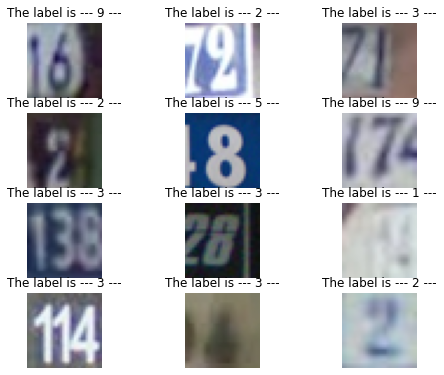

In [95]:
#Selecting a random images and labels and printing them 
random = np.random.randint(0,1000,13)
train_data_sam = train_data[:,:,:,random]
fig = plt.figure(figsize=(8,8))
for i in range(1,13):
  img = train_data_sam[:,:,:,i]
  fig.add_subplot(5,3,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('The label is --- {} ---'.format(train_labels[i]))
plt.show()

In [84]:
#grayscaling train and test data. 
gray_train = []
for i in range(train_data.shape[3]):
  a = (train_data[:,:,0,i]+train_data[:,:,1,i]+train_data[:,:,2,i])/3
  gray_train.append(a)
train_data_gray = np.asarray(gray_train)

gray_test = []
for i in range(test_data.shape[3]):
  a = (test_data[:,:,0,i]+test_data[:,:,1,i]+test_data[:,:,2,i])/3
  gray_test.append(a)
test_data_gray = np.asarray(gray_test)
test_data_gray.shape

(26032, 32, 32)

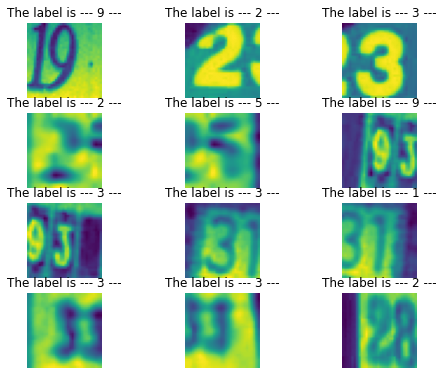

In [91]:
random_2 = np.random.randint(0,1000,13)
train_data_gray_sam = train_data_gray[random_2,:,:]
fig = plt.figure(figsize=(8,8))
for i in range(1,13):
  img = train_data_gray[i,:,:]
  fig.add_subplot(5,3,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('The label is --- {} ---'.format(train_labels[i]))
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
#model with 5 dense layers, L2 regularization, dropout and Adam optimizer
def get_mpl_model(wd,t_d):
  model = Sequential([
                      Flatten(input_shape=t_d),
                      Dense(256, kernel_regularizer=regularizers.L2(wd),kernel_initializer='he_normal', bias_initializer='ones'),
                      Dense(128, kernel_regularizer=regularizers.L2(wd),activation='relu'),
                      Dense(64, kernel_regularizer=regularizers.L2(wd),activation='relu'),
                      Dense(10, activation='softmax')
  ])
  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  
  return model

In [ ]:
model = get_mpl_model(1e-5,train_data_gray[0].shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Callbacks
def scheduler(epoch,lr):
  if epoch<6:
    return lr 
  else:
    return lr*tf.math.exp(-0.05)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp

def checkpoint_best_cnn():
  path = 'checkpoint_best_cnn/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
def train_model(model, train_data, train_labels, epochs):
  callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best()]
  return model.fit(train_data, train_labels,epochs=epochs, 
      batch_size=16, validation_split=0.15,
      callbacks=callbacks,
      verbose=1)
def train_cnn_model(model, train_data, train_labels, epochs):
  callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best_cnn()]
  return model.fit(x=train_data, y=train_labels,epochs=epochs, 
      batch_size=32, validation_split=0.15,
      callbacks=callbacks,
      verbose=1)

In [ ]:
history = train_model(model, train_data_gray, train_targets, 30)

Epoch 1/30
3892/3892 [==============================] - 12s 3ms/step - loss: 1.9738 - accuracy: 0.2971 - val_loss: 1.5251 - val_accuracy: 0.4788

Epoch 00001: val_accuracy improved from -inf to 0.47884, saving model to checkpoint_best/checkpoint
Epoch 2/30
3892/3892 [==============================] - 11s 3ms/step - loss: 1.2952 - accuracy: 0.5781 - val_loss: 1.2590 - val_accuracy: 0.5970

Epoch 00002: val_accuracy improved from 0.47884 to 0.59696, saving model to checkpoint_best/checkpoint
Epoch 3/30
3892/3892 [==============================] - 11s 3ms/step - loss: 1.0856 - accuracy: 0.6597 - val_loss: 1.0020 - val_accuracy: 0.6815

Epoch 00003: val_accuracy improved from 0.59696 to 0.68150, saving model to checkpoint_best/checkpoint
Epoch 4/30
3892/3892 [==============================] - 11s 3ms/step - loss: 0.9695 - accuracy: 0.6985 - val_loss: 0.8959 - val_accuracy: 0.7202

Epoch 00004: val_accuracy improved from 0.68150 to 0.72017, saving model to checkpoint_best/checkpoint
Epoch 5

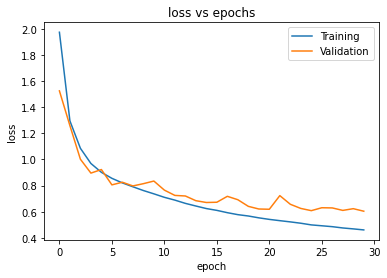

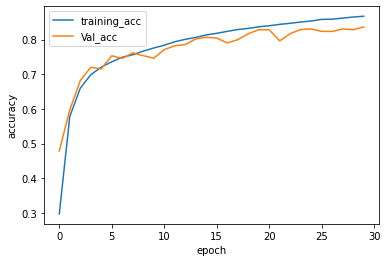

In [61]:
#plotting the loss for training and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
#plotting the accuracy for both, training and validation set. 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training_acc','Val_acc'])
plt.show()

In [62]:
def get_test_accuracy(model, x_test, y_test):
  test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
  print('accuracy: {acc:0.3f}'.format(acc=test_acc))
  print('loss: {loss:0.3f}'.format(loss=test_loss))

In [63]:
get_test_accuracy(model, test_data_gray, test_targets)

accuracy: 0.809
loss: 0.716


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [58]:

#CNN classifer 
def get_cnn_model(td_shape,w_d,d_r):
  model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same',input_shape=td_shape,
           kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    MaxPooling2D((2,2)),
    Dropout(d_r),
    BatchNormalization(),
    Conv2D(16, kernel_size=(2,2),activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(d_r),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(w_d)),
    Dropout(d_r),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(w_d)),
    Dropout(d_r),
    Dense(10, activation='softmax')
  ])
  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [59]:
train_data_gray_cnn = np.reshape(train_data_gray,(73257,32,32,1))
test_data_gray_cnn = np.reshape(test_data_gray,(26032,32,32,1))
cnn_model = get_cnn_model(train_data_gray_cnn[0].shape, 5e-5, 0.10)
cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 16)        2064      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 8, 8, 16)        

In [60]:
history_cnn = train_cnn_model(cnn_model,train_data_gray_cnn,train_targets,30)

Epoch 1/30
1946/1946 [==============================] - 10s 5ms/step - loss: 1.3944 - accuracy: 0.5370 - val_loss: 0.6122 - val_accuracy: 0.8263

Epoch 00001: val_accuracy improved from -inf to 0.82628, saving model to checkpoint_best_cnn/checkpoint
Epoch 2/30
1946/1946 [==============================] - 10s 5ms/step - loss: 0.7161 - accuracy: 0.7808 - val_loss: 0.6110 - val_accuracy: 0.8149

Epoch 00002: val_accuracy did not improve from 0.82628
Epoch 3/30
1946/1946 [==============================] - 9s 5ms/step - loss: 0.6145 - accuracy: 0.8129 - val_loss: 0.4758 - val_accuracy: 0.8635

Epoch 00003: val_accuracy improved from 0.82628 to 0.86350, saving model to checkpoint_best_cnn/checkpoint
Epoch 4/30
1946/1946 [==============================] - 9s 5ms/step - loss: 0.5623 - accuracy: 0.8301 - val_loss: 0.5119 - val_accuracy: 0.8498

Epoch 00004: val_accuracy did not improve from 0.86350
Epoch 5/30
1946/1946 [==============================] - 9s 5ms/step - loss: 0.5283 - accuracy: 0.

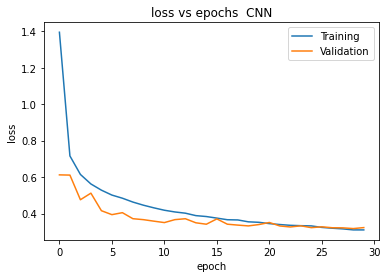

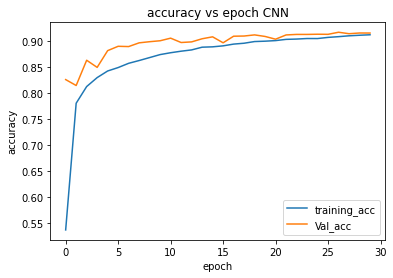

In [64]:
#plotting the loss for training and validation set
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('loss vs epochs  CNN')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
#plotting the accuracy for both, training and validation set. 
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('accuracy vs epoch CNN')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training_acc','Val_acc'])
plt.show()


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [66]:
#MPL model
model = get_mpl_model(1e-5,train_data_gray[0].shape)
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_51 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_53 (Dense)             (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.load_weights('/content/checkpoint_best/checkpoint')
get_test_accuracy(model, test_data_gray, test_targets)

accuracy: 0.809
loss: 0.716


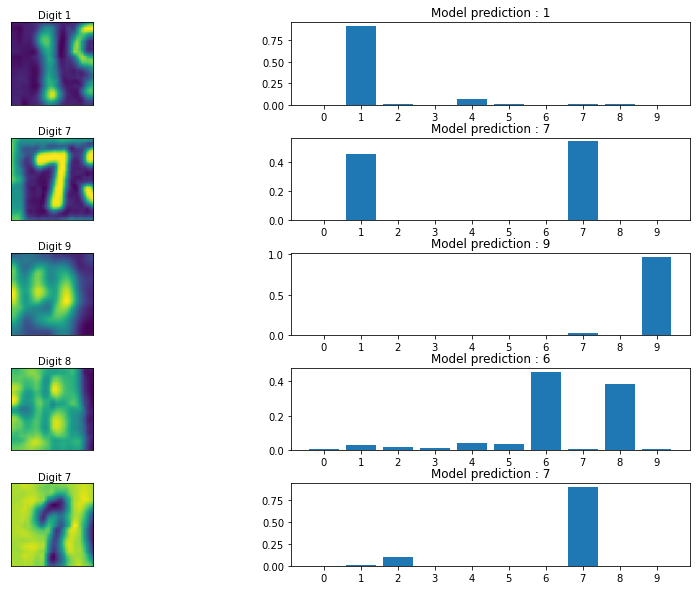

In [70]:
index_random = np.random.choice(test_data_gray.shape[0],5)
random_test_data = test_data_gray[index_random, ...]
random_test_label = test_labels[index_random, ...]

mpl_predictions = model.predict(random_test_data)
fig,axes = plt.subplots(5,2, figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, (mpl_predictions, image, label) in enumerate(zip(mpl_predictions, random_test_data, random_test_label)):
  axes[i,0].imshow(np.squeeze(image))
  axes[i,0].get_xaxis().set_visible(False)
  axes[i,0].get_yaxis().set_visible(False)
  axes[i,0].text(10,-2, f'Digit {label}')
  axes[i,1].bar(np.arange(len(mpl_predictions)),mpl_predictions)
  axes[i,1].set_xticks(np.arange(len(mpl_predictions)))
  axes[i,1].set_title(f'Model prediction : {np.argmax(mpl_predictions)}')
plt.show()

In [71]:
#CNN model
cnn_model = get_cnn_model(train_data_gray_cnn[0].shape, 5e-5, 0.10)
cnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 16)        2064      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 8, 8, 16)        

In [72]:
cnn_model.load_weights('/content/checkpoint_best_cnn/checkpoint')
get_test_accuracy(cnn_model, test_data_gray_cnn,test_targets)

accuracy: 0.904
loss: 0.362


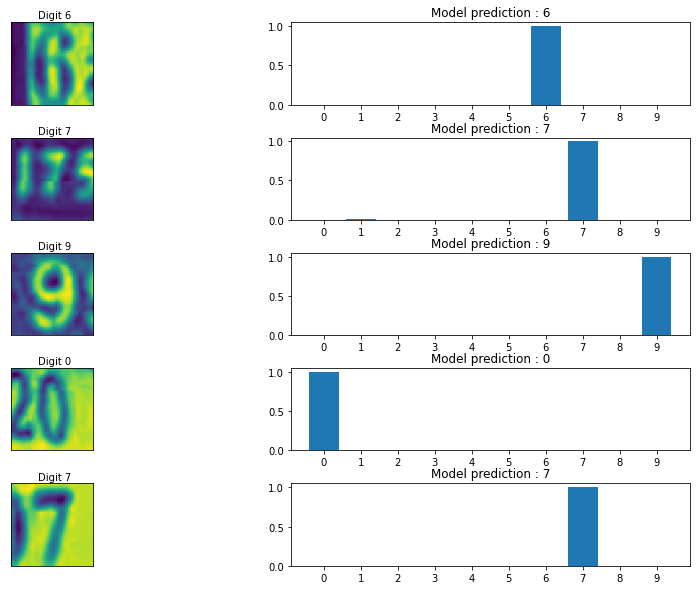

<Figure size 432x288 with 0 Axes>

In [74]:
index_random = np.random.choice(test_data_gray.shape[0],5)
random_test_data = test_data_gray_cnn[index_random, ...]
random_test_label = test_labels[index_random, ...]

cnn_predictions = cnn_model.predict(random_test_data)
fig,axes = plt.subplots(5,2, figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, (mpl_predictions, image, label) in enumerate(zip(cnn_predictions, random_test_data, random_test_label)):
  axes[i,0].imshow(np.squeeze(image))
  axes[i,0].get_xaxis().set_visible(False)
  axes[i,0].get_yaxis().set_visible(False)
  axes[i,0].text(10,-2, f'Digit {label}')
  axes[i,1].bar(np.arange(len(mpl_predictions)),mpl_predictions)
  axes[i,1].set_xticks(np.arange(len(mpl_predictions)))
  axes[i,1].set_title(f'Model prediction : {np.argmax(mpl_predictions)}')
plt.show()
plt.savefig('gif.png')